In [46]:
import pandas as pd 
## making a request to the API
import requests
import json
import os
import time
import datetime
from helper import *

In [47]:
import requests
import json

In [45]:
# Notebook Documentation

This notebook demonstrates an architecture for retrieving and processing disease-related information based on user input of symptoms. It integrates search, language models, and stateful graph-based control flows. Below is a brief overview of how it works.

## Overview

- **Data & API Setup**:  
    The notebook utilizes libraries such as requests, langchain, langgraph, and elasticsearch. Helper modules load models and generate embeddings for symptom queries.

- **Tool Definitions**:  
    Two primary tools are defined:  
    • `retriever2`: Searches an Elasticsearch index for documents matching symptom embeddings using cosine similarity.  
    • `retriever3`: Calls an external API to predict the disease given a list of symptoms.  

- **Document Grading**:  
    The `grade_documents` function uses an LLM (via `OllamaFunctions`) to score the relevance of retrieved documents using a binary (yes/no) check.

- **State Graph & Agent Architecture**:  
    A state graph is built using langgraph tools to control the conversation flow. An assistant node, connected with tool nodes (and fallback mechanisms), uses a prepared prompt and an LLM (`ChatOllama`) to process user queries. The system iteratively invokes tools until a relevant answer is produced.

- **Execution Flow**:  
    Upon receiving input (e.g., “I have a cough”), the assistant starts the process by invoking the first tool. If insufficient, it falls back to the second tool. Each response is graded for relevance before final output, ensuring meaningful and accurate responses.

This architecture showcases the blend of traditional search mechanisms with modern LLM reasoning in an interactive, stateful notebook environment.

SyntaxError: invalid character '•' (U+2022) (4208055896.py, line 12)

## Real Architecture

In [48]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import MessagesState

from typing import Literal
from typing_extensions import TypedDict


from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

from pydantic import BaseModel, Field
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.prebuilt import ToolNode

from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import HumanMessage, AIMessage

In [49]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from pydantic import BaseModel, Field   


In [50]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_core.tools import tool


In [51]:
def grade_documents(query,docs) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        query: user question
        docs: retrieved documents

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    print("---GRADE DOCUMENTS---")
    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: bool = Field(description="Relevance score 'True' or 'False'")
    # LLM
    model = OllamaFunctions(model="llama3:latest")


    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    scored_result = chain.invoke({"question": query, "context": docs})

    return scored_result
    


@tool
def retriever2(query):
    """
    Function to search for symptoms in Elasticsearch and return the most similar ones.
    Args:
        query (str): The user query containing symptoms.

    Returns:
        results (list): A list of dictionaries containing the disease, symptoms, and score.
    """

    print("---RETRIEVER 2---")
    top_k=1
    model, tokenizer = load_model()
    
    # Generate the embedding for the user query
    query_embedding = generate_embeddings([query], model, tokenizer)[0]

    # Search for the most similar symptoms in Elasticsearch
    script_query = {
        "script_score": {
            "query": {
                "match_all": {}  # Match all documents
            },
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
                "params": {
                    "query_vector": query_embedding.tolist()
                }
            }
        }
    }
    # Function to search for symptoms based on user input

    
    # Perform the search and get the top-k results
    response = es.search(index=index_name, body={
        "size": top_k,
        "query": script_query
    })

    # Parse the response
    results = []
    for hit in response['hits']['hits']:
        score = hit['_score']
        disease = hit['_source']['disease']
        symptoms = hit['_source']['symptoms']
        results.append({"disease": disease, "symptoms": symptoms, "score": score})

    results =results[0]["disease"]

    

    final_result = grade_documents(query, results)
    jso =  {"disease": results,"is_relavant": final_result.binary_score}
    
    return jso

@tool
def retriever3(query):
    """
    Function to get disease prediction from the API by providing symptoms.

    Args:
        query (str): A string of comma-separated symptoms, e.g., "fever,cough,headache".

    Returns:
        str: The predicted disease or an error message if the API call fails.
    """
    print("---RETRIEVER 3---")

    url = 'https://proud-violet-c7b2.kartikeyshaurya.workers.dev'
    
    payload = {
    'data': query,
    }
    headers = {
        'Content-Type': 'application/json'  # Set the content type to JSON
    }

    # Make the POST request
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    print(response)
    if response.status_code == 200:
        # Parse the response JSON
        a = response.json()
        print(a)
        output = a[0]["response"]["response"]

        grade_value = grade_documents(query, output)

        result = {"disease": output, "is_relavant": grade_value.binary_score}
        return result
    else:
        return f'Failed to get response. Status code: {response.status_code}'




In [55]:
retriever2.invoke("what is the capital of France")

---RETRIEVER 2---
---GRADE DOCUMENTS---
---CHECK RELEVANCE---


{'disease': 'Chicken pox', 'is_relavant': False}

In [56]:
retriever3.invoke("what is the capital of France")

---RETRIEVER 3---
<Response [200]>
[{'inputs': {'messages': [{'role': 'system', 'content': 'You are a medical assistant trained to diagnose diseases based on provided symptoms. \n          Your task is to predict the most likely disease given a list of symptoms  and some additional information about disease. \n         \n          Input:\n          - Symptoms/additional information:  what is the capital of France\n          \n          Output:\n          - Predicted Disease: [Name of disease]'}]}, 'response': {'response': 'I\'m happy to help! However, I must point out that the input "what is the capital of France" is not related to symptoms or medical information, and therefore, I cannot diagnose a disease based on this input.\n\nAs a medical assistant, I require specific symptoms and medical information to make an accurate diagnosis. If you could provide me with a list of symptoms and additional relevant medical information, I would be happy to help you predict the most likely disease

{'disease': 'I\'m happy to help! However, I must point out that the input "what is the capital of France" is not related to symptoms or medical information, and therefore, I cannot diagnose a disease based on this input.\n\nAs a medical assistant, I require specific symptoms and medical information to make an accurate diagnosis. If you could provide me with a list of symptoms and additional relevant medical information, I would be happy to help you predict the most likely disease.\n\nPlease provide me with the necessary information, and I\'ll do my best to assist you.',
 'is_relavant': True}

##  architecture 1 

In [57]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [58]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



In [59]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

In [60]:

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant who helps the user to answer the question related to query. "
            " Use the provided tools to search for relavent input from the user. "
            "start with the first tool and if it fails to find the relavent answer, use the second tool. "
            " if retriver2 fails to find the relavent answer, use retriever3 to search for the relavent input. "
        ),
        ("placeholder", "{messages}"),
        
    ])

In [61]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:3b")
llm_with_tool = [retriever2, retriever3]


In [62]:
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(llm_with_tool)


In [63]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(llm_with_tool))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

In [64]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

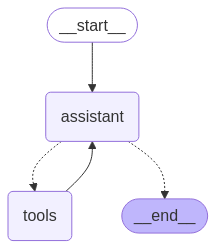

In [65]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [66]:
import uuid
thread_id = str(uuid.uuid4())

In [67]:
config = {
    "configurable": {
        "thread_id": thread_id,
    }
}

In [68]:
events = part_1_graph.stream(
        {"messages": ("user", "i have a cough ")}, config, stream_mode="values"
    )

In [69]:
_printed = set()

for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

i have a cough 
================================== Ai Message ==================================
Tool Calls:
  retriever3 (207bb66b-5bb0-48cc-b3f4-8e4f82f58750)
 Call ID: 207bb66b-5bb0-48cc-b3f4-8e4f82f58750
  Args:
    query: cough
---RETRIEVER 3---
<Response [200]>
[{'inputs': {'messages': [{'role': 'system', 'content': 'You are a medical assistant trained to diagnose diseases based on provided symptoms. \n          Your task is to predict the most likely disease given a list of symptoms  and some additional information about disease. \n         \n          Input:\n          - Symptoms/additional information:  cough\n          \n          Output:\n          - Predicted Disease: [Name of disease]'}]}, 'response': {'response': 'Based on the symptom "cough", I predict the most likely disease to be:\n\n**Pneumonia**\n\nAdditional information: Pneumonia is a common respiratory infection that can cause a seve

---RETRIEVER 2---


'Common Cold'